In [1]:
# REF: https://arxiv.org/pdf/0704.1317.pdf

# import libraries
import numpy as np
import scipy
from scipy import interpolate


import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Create an integer messege vector b

b = np.array([3,6,7,2,5,2])

# create H here n = 6 d = 3 normalize H to get |det(G)| = |det(H)| = 1

H = np.array([[0, -0.8, 0, -0.5, 1, 0],[0.8, 0, 0, 1, 0, -0.5],[0, 0.5, 1, 0, 0.8, 0],[0, 0, -0.5, -0.8, 0, 1],[1, 0, 0, 0, 0.5, 0.8],[0.5, -1, -0.8, 0, 0, 0]])

H_norm = H/np.abs(np.linalg.det(H))**(1/6.)

# Calculate generator matrix G = inv(H) normalize H to get |det(G)| = 1

G = np.linalg.inv(H_norm)

# Calculate codeword x

x = np.dot(G,b)

x = x.reshape(-1,1)

# create noisy codeword y = x + w

mu, sigma = 0, 10 # mean and standard deviation
w = np.random.normal(mu, sigma, x.shape)
y = x + w

# y is user input fingerprint
x_input = np.arange(-200.0,200.1,0.1)



In [3]:
"""
check node --- Q ---> variable node
variable node --- f ---> check node

"""
# Write a funtion that will return check and variable nodes from H matrix

def _ChkandVarNodes(H):
    """Return check and variable nodes of a parity-check matrix H.
    Example:
    
    H = array([[ 0. , -0.8,  0. , -0.5,  1. ,  0. ],
       [ 0.8,  0. ,  0. ,  1. ,  0. , -0.5],
       [ 0. ,  0.5,  1. ,  0. ,  0.8,  0. ],
       [ 0. ,  0. , -0.5, -0.8,  0. ,  1. ],
       [ 1. ,  0. ,  0. ,  0. ,  0.5,  0.8],
       [ 0.5, -1. , -0.8,  0. ,  0. ,  0. ]])
       
    cnode_idx,cnode,vnode_idx,vnode = _ChkandVarNodes(H)
    
    cnode_idx,cnode,vnode_idx,vnode = 
    
    (array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]),
     array([1, 4, 5, 0, 2, 5, 2, 3, 5, 0, 1, 3, 0, 2, 4, 1, 3, 4]),
     array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]),
     array([1, 3, 4, 0, 3, 5, 1, 2, 4, 2, 3, 5, 0, 4, 5, 0, 1, 2]))
    
    EACH ROW IS 1 VARIABLE NODE!
    EACH COULMN IS 1 CHECK NODE!
    
    So for check node chk_id is the column index
    """
    if type(H) != scipy.sparse.csr_matrix:
        vnode_indices, vnode_nodes = np.where(H)
        cnode_indices, cnode_nodes = np.where(H.T)
    else:
        vnode_indices, vnode_nodes = scipy.sparse.find(H)[:2]
        cnode_indices, cnode_nodes = scipy.sparse.find(H.T)[:2]
    #chk_histogram = np.bincount(chk_indices)
    #var_histogram = np.bincount(var_indices)

    return cnode_indices, cnode_nodes, vnode_indices, vnode_nodes

In [4]:
# x1, x2, x3, x4,...,xn -> variable node c1,c2,....,cn -> check node
# Initialization from variable to check node

def init_message(x, mat):
    # produces f_k^0(x)
    """
    initial message vector
    
    INPUT
    x (1d array) - input suport vactor
    mat - parity-check matrix.
    
    OUTPUT
    variable node outgoing message
    """
    global sigma
    nvnode,ncnode = mat.shape     
    # initialize outgoing variable messege
    cnode_message = np.zeros(shape = (ncnode,nvnode,len(x)))
    cnode_idx,cnode,_,_ = _ChkandVarNodes(mat)

    cnode_message[tuple([cnode_idx,cnode])] = (np.exp(-(((H[tuple([cnode,cnode_idx])].reshape(-1,1) - x)/sigma)**2)/2.))/(np.sqrt(2*np.pi*sigma**2))
        
    return cnode_message

In [5]:
def extrapolate(x_in,y):
    """
    Given an array, returns the extrapolated function f(x_in)
    y = f(arr)
    
    INPUT
    x_in (1d array) - range of the array
    y (1d array) - array to be interpolated
    
    OUTPUT
    interpolated funtion f(arr)
    """
    f = interpolate.interp1d(x_in, y, fill_value = "extrapolate")
    return f

In [17]:
#Check node will receive a list of varibale node messages.

class CheckNode:
    def __init__(self,H,x):
        """
        initialize CheckNode class

        INPUT
        h (array) - h is the elements of a row from H ex: [0,-0.8,0,-0.5,1,0]
        j (int) - jth check node
        """
        self.H = H
        #self.cnode_id,self.cnode,self.vnode_id,self.vnode = _ChkandVarNodes(H)
        
        # cnode_id --> vnode_ids
        self.vnode_id = [list(H[:,i].nonzero()[0]) for i in range(H.shape[1])] 
        # vnode_id --> cnode_ids
        self.cnode_id = [list(H[i,:].nonzero()[0]) for i in range(H.shape[0])] 
        
        self.nvnode,self.ncnode = H.shape 
        self.x = x
        # initialize outgoing check messege
        self.cnode_message = np.zeros(shape = (self.nvnode,self.ncnode,len(self.x)))
        
    def pj(self,chk_idx,var_idx,vnode_message,x_in = None):
        """
        convolve all messages except f_j(x)
        x (array) - input suport vactor
        message (2d matrix) - incoming variable node messages of the form (numvar,len(x))
        chk_idx (int) - check node id
        var_idx (int) - variable node id
        Returns p_j(x)
        """
        
        if x_in is None:
            x_in = self.x
        else:
            assert len(x_in) == len(self.x), "length mismatch!"
            
        assert vnode_message.shape == (self.ncnode, self.nvnode, len(self.x))
        
        # extrapolation should always be on support vector self.x
        vnode_message_func = extrapolate(self.x,vnode_message)
        var_ids =  np.asarray(self.vnode_id[chk_idx])
        p_j = 1
        for i in var_ids[var_ids != var_idx]:
            val = self.H[i,chk_idx]
            p_j = np.convolve(p_j,vnode_message_func(x_in/val)[chk_idx][i].ravel(),mode='full')
        return p_j 
    
    def _conv1node(self,chk_idx,vnode_message,x_in = None):
        """
        convolve all messages for 1 check node
        x (array) - input suport vactor
        message (2d matrix) - incoming variable node messages of the form (numvar,len(x))
        chk_idx (int) - check node id
        Returns p_j(x)
        """
        if x_in is None:
            x_in = self.x
        else:
            assert len(x_in) == len(self.x), "length mismatch!"
            
        var_message = []
        var_idx =  np.asarray(self.vnode_id[chk_idx])
        for idx in var_idx:
            p_j = 1
            p_j = self.pj(chk_idx,idx,vnode_message,x_in)
            var_message.append(p_j)            
                    
        return var_message     
        
    def conv_all_node(self,vnode_message,x_in = None):
        """
        convolve all checknode messages
        x (array) - input suport vactor
        vnode_message (nd matrix) - incoming variable node messages of the form (numchk,numvar, len(x))
        
        Returns p_j(x)
        """
        if x_in is None:
            x_in = self.x
        else:
            assert len(x_in) == len(self.x), "length mismatch!"
            
        allmsg = []
        
        for i in range(self.ncnode):
            msg = self._conv1node(i,vnode_message)
            allmsg.append(msg)        
        return allmsg
        

    def stretch_pj(self,chk_idx,var_idx,vnode_message):
        """
        The result is stretched by -h_j
        x_in (array) - input suport vactor
        
        RETURNS p_j(-h_j*x)
        """
        
#         if x_in is None:
#             x_in = self.x
#         else:
#             assert len(x_in) == len(self.x), "length mismatch!"
            
        h_j = self.H[var_idx,chk_idx]
        p_j = self.pj(chk_idx,var_idx,vnode_message, x_in = -h_j*self.x)
        return p_j
    
    def periodic_extension(self,chk_idx,vnode_message,x_in = None):
        """
        The result is extended to a periodic function with period 1/|hj|:
        x (array) - input suport vactor
        
        RETURNS Q_j(x)
        """
        h = np.abs(self.h)
        minval = h[np.nonzero(h)].min()
        end = np.rint(x.max()*minval) # 100
        i = np.rint(x.min()*minval) # -100
        q = 1
        while i < end:
            q += CheckNode.stretch(self, x - i/self.h[self.j])
            i += 1
        return q
    def Q(self,vnode_message):
        """        
        RETURNS Q_j(x)
        """
        return CheckNode.periodic_extension(self,x)

In [18]:
node = CheckNode(H,x_input)
# node

In [22]:
result = init_message(x_input, H)
convolution = node.pj(0,5,vnode_message = result,x_in = x_input)
stretch = node.stretch_pj(0,5,vnode_message = result)

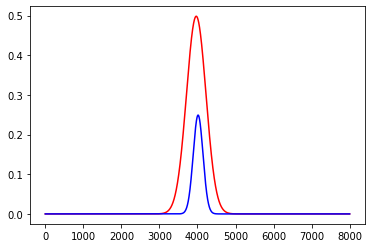

In [23]:
plt.plot(range(len(stretch)),stretch,'r');
plt.plot(range(len(stretch)),convolution,'b');

## Testing 

In [10]:
node.vnode_id

[[1, 4, 5], [0, 2, 5], [2, 3, 5], [0, 1, 3], [0, 2, 4], [1, 3, 4]]

In [11]:
result.shape

(6, 6, 4001)

In [12]:
result[1]

array([[2.72580707e-88, 3.32647957e-88, 4.05911333e-88, ...,
        1.65988720e-89, 1.35811764e-89, 1.11109904e-89],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.02850618e-89, 2.47873822e-89, 3.02859753e-89, ...,
        2.23337648e-88, 1.82972294e-88, 1.49887460e-88],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.05911333e-88, 4.95260924e-88, 6.04217809e-88, ...,
        1.11109904e-89, 9.08918044e-90, 7.43452539e-90]])

In [13]:
chkh,chk,varh,var = _ChkandVarNodes(H)

In [14]:
chkh,chk,varh,var

(array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]),
 array([1, 4, 5, 0, 2, 5, 2, 3, 5, 0, 1, 3, 0, 2, 4, 1, 3, 4]),
 array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]),
 array([1, 3, 4, 0, 3, 5, 1, 2, 4, 2, 3, 5, 0, 4, 5, 0, 1, 2]))

In [15]:
H[tuple([chk,chkh])] 

array([ 0.8,  1. ,  0.5, -0.8,  0.5, -1. ,  1. , -0.5, -0.8, -0.5,  1. ,
       -0.8,  1. ,  0.8,  0.5, -0.5,  1. ,  0.8])

In [16]:
d = dict()
d.keys() = chkh
d.values() = chk

SyntaxError: can't assign to function call (<ipython-input-16-e3cb67bc0126>, line 2)

In [ ]:
tuple([chk,chkh])

In [ ]:
import matplotlib.pyplot as plt



In [ ]:
result[6]

In [ ]:
plt.plot(result[6]);

In [ ]:
H = np.array([[0, -0.8, 0, -0.5, 1, 0,1],[0.8, 0, 0, 1, 0, -0.5,1],[0, 0.5, 1, 0, 0.8, 0,1],[0, 0, -0.5, -0.8, 0, 1,1],[1, 0, 0, 0, 0.5, 0.8,1],[0.5, -1, -0.8, 0, 0, 0,1]])

In [ ]:
H

In [ ]:
nvar,nchk = H.shape 

In [ ]:
H[tuple([chk,chkh])].reshape(-1,1)
(np.exp(-(((H[tuple([chk,chkh])].reshape(-1,1) - x_input)/sigma)**2)/2.))/(np.sqrt(2*np.pi*sigma**2))

In [ ]:
#extrapolation on veactor?

f = interpolate.interp1d(x_input, result, fill_value = "extrapolate")

In [ ]:
tuple([cnode,cnode])

In [ ]:
plt.plot(x_input,f(x_input/0.8)[0][4]);
plt.plot(x_input,f(x_input/0.5)[0][1]);
plt.plot(x_input,f(x_input)[0][5]);

In [ ]:
plt.plot(x_input,result[0,1])

In [ ]:
f(x_input)[0]

In [ ]:
f(x_input)[0][:3]

In [ ]:
f(x_input)[0].shape[0]

In [ ]:
def _conv1node(x_in,chk_idx):
        """
        convolve all messages except f_j(x)
        x (array) - input suport vactor
        message (2d matrix) - incoming variable node messages of the form (numvar,len(x))
        chk_idx (int) - check node id
        Returns p_j(x)
        """
        var_message = []
        var_idx =  H[:,chk_idx].nonzero()[0]
        p_j = 1
        for idx in var_idx:
            for i in var_idx[var_idx != idx]:
                val = H[i,chk_idx]
                p_j = np.convolve(p_j,f(x_in/val)[chk_idx][i].ravel(),mode='full')
            var_message.append(p_j)
            p_j = 1
        return var_message , list(var_idx)

In [ ]:
_conv1node(x_input,1)[1]

In [ ]:
import timeit

In [ ]:
timeit.timeit('allchknode(x_input,np.arange(6))', 'from __main__ import np, allchknode,x_input', number=1000)

In [ ]:
plt.plot(np.arange(8001),_conv1node(x_input,1)[0][0]);
#plt.plot(np.arange(8001),_conv1node(x_input,1)[0][1]);
plt.plot(np.arange(8001),_conv1node(x_input,1)[0][2]);

In [ ]:
var_idx,chk_idx = 3,1
p_j = 1
for idx in H[:,chk_idx].nonzero()[0]:
    val = H[tuple([idx,chk_idx])]
    p_j = np.convolve(p_j,f(x_input/val)[chk_idx][idx].ravel(),mode='full')

In [ ]:
H

In [ ]:
for i in range (6):
    #plt.plot(x_input,_conv1node(x_input,i,1))
    print (_conv1node(x_input,i)[1])


In [ ]:
for idx in H[:,chk_idx].nonzero()[0]:
    print (idx, H[tuple([idx,chk_idx])]) 

In [ ]:
H[:,chk_idx].nonzero()[0], H[tuple([H[:,chk_idx].nonzero()[0],chk_idx])]

In [ ]:
vnode_idx =  H[:,chk_idx].nonzero()[0]
#for 

In [ ]:
from itertools import combinations
list(combinations(vnode_idx,2))


In [ ]:
for i in vnode_idx:
    #for j in vnode_idx:
    print vnode_idx[]    

In [ ]:
vnode_idx[vnode_idx != 5] 